# Best practice for plotting batch-runs

In [1]:
import os
import bokeh
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cellpy import cellreader
from cellpy.utils import ica
from cellpy.exceptions import NullData
import holoviews as hv
import altair as alt
%matplotlib inline

### Setting file names and loading data

In [2]:
my_data = cellreader.CellpyData()
filename = "../testdata/hdf5/20160805_test001_45_cc.h5"
assert os.path.isfile(filename)

In [3]:
my_data.load(filename)
my_data.set_mass(0.1)

/Users/jepe/scripting/cellpy/cellpy/readers/cellreader.py:846: UserWarning: OLD-TYPE: Recommend to save in new format!
  warnings.warn("OLD-TYPE: Recommend to save in new format!")


In [4]:
df_ica_charge, df_ica_discharge = ica.ica_frames(my_data)

no steps found (c:18 s:0 type:charge)


/Users/jepe/miniconda3/envs/cellpy/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [7]:
df_ica_charge.head()

,voltage,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
,v,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq,dq
0,0.107166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.116185,2519.950322,2363.935462,2156.213995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.125205,2477.984602,2256.832187,2048.303451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.134225,3572.263901,3467.901396,3291.390325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.143244,4604.181277,4555.014823,4263.244182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2273.385348,NaN,NaN,2307.505841,NaN


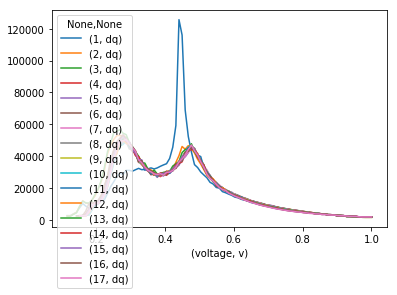

In [8]:
df_ica_charge.plot(x=("voltage", "v"))

### Checking the data

#### voltage cycles

In [ ]:
capacity, voltage = my_data.get_cap()

In [ ]:
plt.plot(capacity, voltage)

In [ ]:
cycles = my_data.get_cycle_numbers()

In [ ]:
charge_cycles = list()
for c in cycles:
    try:
        ccv = my_data.get_ccap(c)
        charge_cycles.append(ccv)
    except NullData:
        print(f"Cycle {c}: no data")
        
charge_cycles = np.array(charge_cycles)

In [ ]:
for x,y in discharge_cycles:
    plt.plot(x,y)

In [ ]:
def make_charge_list(data):
    """Create a list of pandas.DataFrames, one for each charge step.
    
    The DataFrames are named by its cycle number.
    
    Input: CellpyData
    Returns: list of pandas.DataFrames
        minimum voltage value,
        maximum voltage value"""
    
    minimum_v_value = np.Inf
    maximum_v_value = -np.Inf
    charge_list = []
    cycles = my_data.get_cycle_numbers()
    for cycle in cycles:
        try:
            q, v = data.get_ccap(cycle)
        except NullData as e:
            print(e)
            break
        else:
            d = pd.DataFrame({"q": q, "v": v})
            #d.name = f"{cycle}"
            d.name = cycle
            charge_list.append(d)
            v_min = v.min()
            v_max = v.max()
            if v_min < minimum_v_value:
                minimum_v_value = v_min
            if v_max > maximum_v_value:
                maximum_v_value = v_max
    return charge_list, minimum_v_value, maximum_v_value


In [ ]:
charge_dfs, minimum_v, maximum_v = make_charge_list(my_data)

In [ ]:
charge_df = pd.concat(charge_dfs, axis=1, keys=[k.name for k in charge_dfs])

In [ ]:
charge_df.head(3)

In [ ]:
n1, n2, n3 = (1, 3, 8)
ax = charge_df[n1].plot(x="q", y="v", label=f"cycle {str(n1).zfill(2)}")
charge_df[n2].plot(x="q", y="v", ax=ax, label=f"cycle {str(n2).zfill(2)}")
charge_df[n3].plot(x="q", y="v", ax=ax, label=f"cycle {str(n3).zfill(2)}")

### Checking ica

In [ ]:
c, v = charge_cycles[2]
dq, dv = ica.dqdv(v, c)
plt.plot(dq,dv)

In [ ]:
print(f"min, max = ({minimum_v} {maximum_v})")

## Creating dqdv-data

In [ ]:
def custom_dq_dv(capacity, voltage, minimum_v, maximum_v):
    converter = ica.Converter()
    converter.set_data(capacity, voltage)
    converter.inspect_data()
    converter.pre_process_data()
    converter.increment_data()
    converter.fixed_voltage_range = [minimum_v, maximum_v, 100]
    converter.post_process_data()
    return converter.voltage_processed, converter.incremental_capacity

In [ ]:
incremental_charge_list = []
for (cap, volt), cycle in zip(charge_cycles, cycles):
    if cap.any():
        dv, dq = custom_dq_dv(cap, volt, minimum_v, maximum_v)
        if not incremental_charge_list:
            d = pd.DataFrame({"dv": dv})
            d.name = "voltage"
            incremental_charge_list.append(d)

            d = pd.DataFrame({f"dq": dq})
            d.name = cycle
            incremental_charge_list.append(d)
            
        else:
            d = pd.DataFrame({f"dq": dq})
            #d.name = f"{cycle}"
            d.name = cycle
            incremental_charge_list.append(d)
    else:
        print(f"{cycle} is empty")

In [ ]:
ica_df = pd.concat(incremental_charge_list, axis=1, keys=[k.name for k in incremental_charge_list])

In [ ]:
ica_df.columns.names = ["cycle", "value"]

In [ ]:
ica_df.head(12)

In [ ]:
ica_df.plot(x=("voltage","dv"))

**Success!**

In [ ]:
ica_df.head()

In [ ]:
ica_long_multiindex = ica_df.copy()

In [ ]:
ica_long_multiindex.head()

In [ ]:
long_multiindex = ica_long_multiindex.melt("voltage", var_name="cycle", value_name="dq", col_level=0)

In [ ]:
long_multiindex.head()

In [ ]:
long_multiindex.tail()

### Plotting with Altair

In [ ]:
alt.renderers.enable('notebook')

|   Data Type    |    Shorthand Code   |   Description                     |
|----------------|---------------------|-----------------------------------|
| quantitative   | Q                   | a continuous real-valued quantity |
|ordinal | O | a discrete ordered quantity|
|nominal | N | a discrete unordered category|
|temporal | T | a time or date value|

In [ ]:
alt.Chart(long_multiindex).mark_line().encode(
  x='voltage:Q',
  y='dq:Q',
  color='cycle:O'
).interactive()

In [ ]:
import altair as alt
from vega_datasets import data

stocks = long_multiindex

highlight = alt.selection(type='single', on='mouseover',
                          fields=['cycle'], nearest=True)

base = alt.Chart(stocks).encode(
    x='voltage:Q',
    y='dq:Q',
    color='cycle:O'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(3))
).interactive()

points + lines

Easy...but a bit limiting?

### Trying Bokeh

The main benifit with using Bokeh: interactive html

In [ ]:
from bokeh.io import output_notebook
output_notebook()

In [ ]:
# trick to flatten the multiindex (not sure if HoloViews takes multiindex)
# ica_df.columns = ['_'.join(col).strip() for col in ica_df.columns.values]

In [ ]:
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral11, Paired, Viridis256
from bokeh.models.glyphs import MultiLine, Line
from bokeh.io import show
import itertools
from bokeh.transform import linear_cmap

In [ ]:
# source = ColumnDataSource(ica_df) # bokeh automatically flattens multiindexed columns using "_".join(k) (i.e. must be str)
# source.data

In [ ]:
source = ColumnDataSource(long_multiindex)

In [ ]:
xrange = DataRange1d()
yrange = DataRange1d()
plot = figure(x_range=xrange, y_range=yrange, plot_width=800, plot_height=300)
plot.line(source=source, x="voltage", y="dq", legend="cycle") #, line_color=linear_cmap('cycle', "Viridis256", 0, 255))
show(plot)
# How can I set a color palette? mappers?

Not sure if I want to do this anymore. Bokeh is a little bit of a "luremus"..
Lets check if Holoviews makes life a little bit easier.

### Plotting with HoloViews

In [ ]:
hv.extension('bokeh')

In [ ]:
curve = hv.Curve(long_multiindex, kdims=['voltage', "dq"], vdims=['cycle'])
curve

In [ ]:

curve2 = hv.Curve(long_multiindex, kdims=["voltage", "dq"], vdims="cycle")
curve2

In [ ]:
long_multiindex.head()

In [ ]:
from bokeh.sampledata.iris import flowers
from holoviews.operation import gridmatrix

iris_ds = hv.Dataset(flowers)

In [ ]:
%%opts Bivariate [bandwidth=0.5] (cmap='Blues') Points [tools=['box_select']] (size=2)
density_grid = gridmatrix(iris_ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(iris_ds, chart_type=hv.Points)

density_grid * point_grid